In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
changed = False
if not changed:
    os.chdir("..")
    changed = True
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee

In [2]:
config_path = "configs/configs_mice_F"
temp_results_path = "temp_results/Mice_F" 
results_path = "results_csvs/Mice_F" 
apply_thresh = True


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = int(config.get('DEFAULT', 'prior'))
transform = bool(config.get('DEFAULT', 'transform'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(current_folder)[-1]
seed_file = seed_file.split(current_folder)[-1]
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths
data_file = data_file[1:]
seed_file = seed_file[1:]
submission_folder = submission_folder[1:]



h5_folder = f"{submission_folder}/h5_files"

In [5]:
ds = dtds.dsFromFile(data_file)
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading Mice_F


In [6]:
print("$F_x=\\beta^2/\\eta x_c$")

$F_x=\beta^2/\eta x_c$


In [7]:
samples_trans0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


thresh: -23494.421228141404


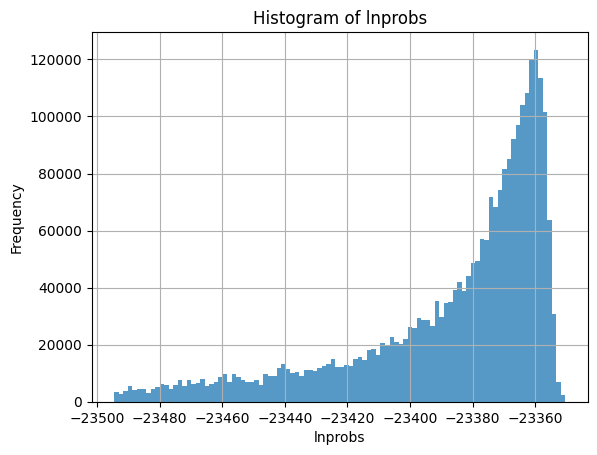

In [8]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 30)
print(f"thresh: {thresh}")

plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [9]:
if apply_thresh:
    samples_trans = samples_trans0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

In [10]:
sorted_samples_trans = samples_trans[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
p1,p2,p3,p4 = srmc.get_params_from_thetas(sorted_samples_trans)
medians_trans = [np.median(p1),np.median(p2),np.median(p3),np.median(p4)]
means_trans = [np.mean(p1),np.mean(p2),np.mean(p3),np.mean(p4)]
stds_trans = [np.std(p1),np.std(p2),np.std(p3),np.std(p4)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev_trans = [median_abs_deviation(p1),median_abs_deviation(p2),median_abs_deviation(p3),median_abs_deviation(p4)]

In [11]:
samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])

In [12]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
etas,betas,epsilons,xcs = srmc.get_params_from_thetas(sorted_samples)
medians = [np.median(etas),np.median(betas),np.median(epsilons),np.median(xcs)]
means = [np.mean(etas),np.mean(betas),np.mean(epsilons),np.mean(xcs)]
stds = [np.std(etas),np.std(betas),np.std(epsilons),np.std(xcs)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev = [median_abs_deviation(etas),median_abs_deviation(betas),median_abs_deviation(epsilons),median_abs_deviation(xcs)]



In [13]:
if False:
    from SRtools import samples_utils as ssu
    from SRtools import config_lib as ccl
    config_dict = ccl.config_to_dict(config)
    path1 = 'mice_F.csv'
    post_path = os.path.join('posterior_csvs',path1.replace('.csv','_post.csv'))

    help_text ="run from baysian01"

    post = ssu.Posterior(samples_trans, lnprobs, 100, log=True,config_params=config_dict,help_text=help_text)
    post.save_to_file(post_path)

Averaging log-probabilities: 100%|██████████| 22945/22945 [00:00<00:00, 406063.66it/s]


(16,)


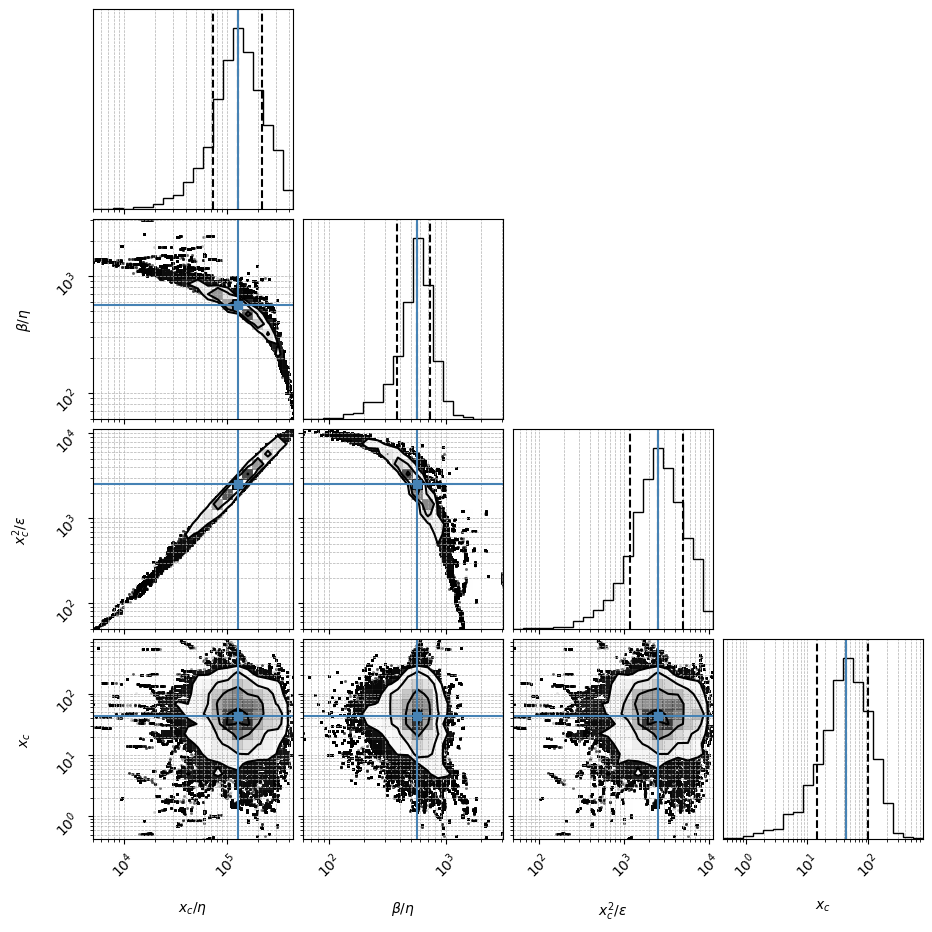

In [13]:
fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians_trans)
axes=fig.get_axes()
print(np.shape(axes))
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

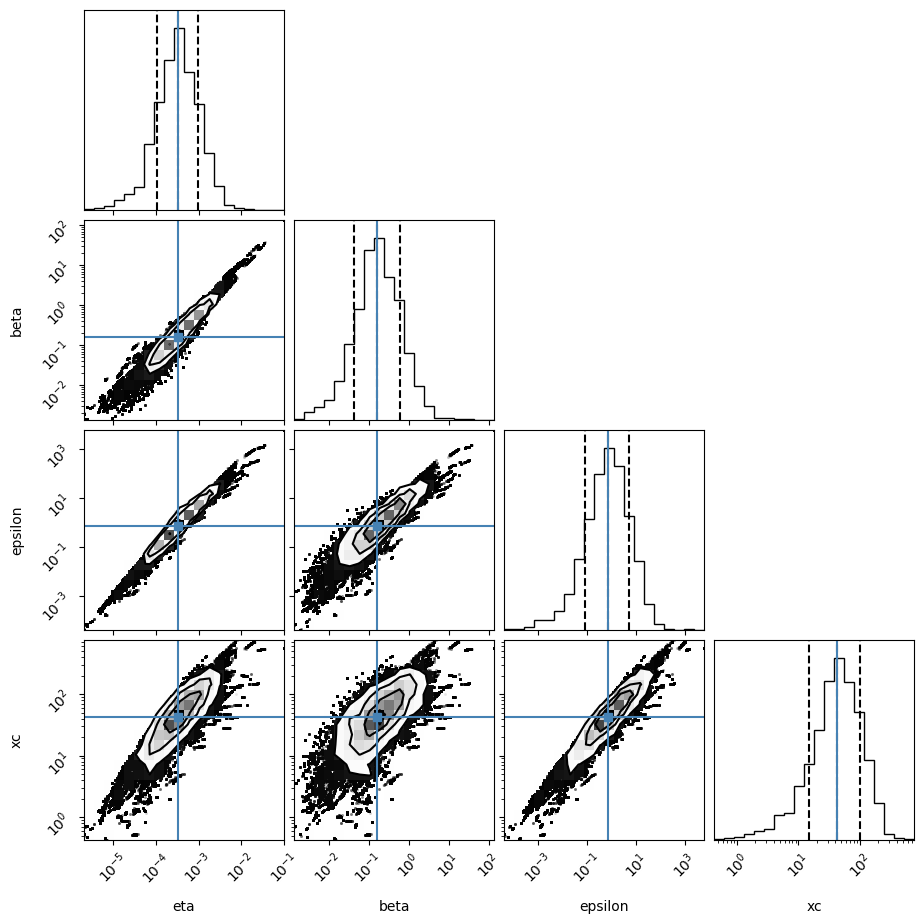

In [14]:
fig = corner.corner(samples, labels=['eta','beta','epsilon','xc'],axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians)

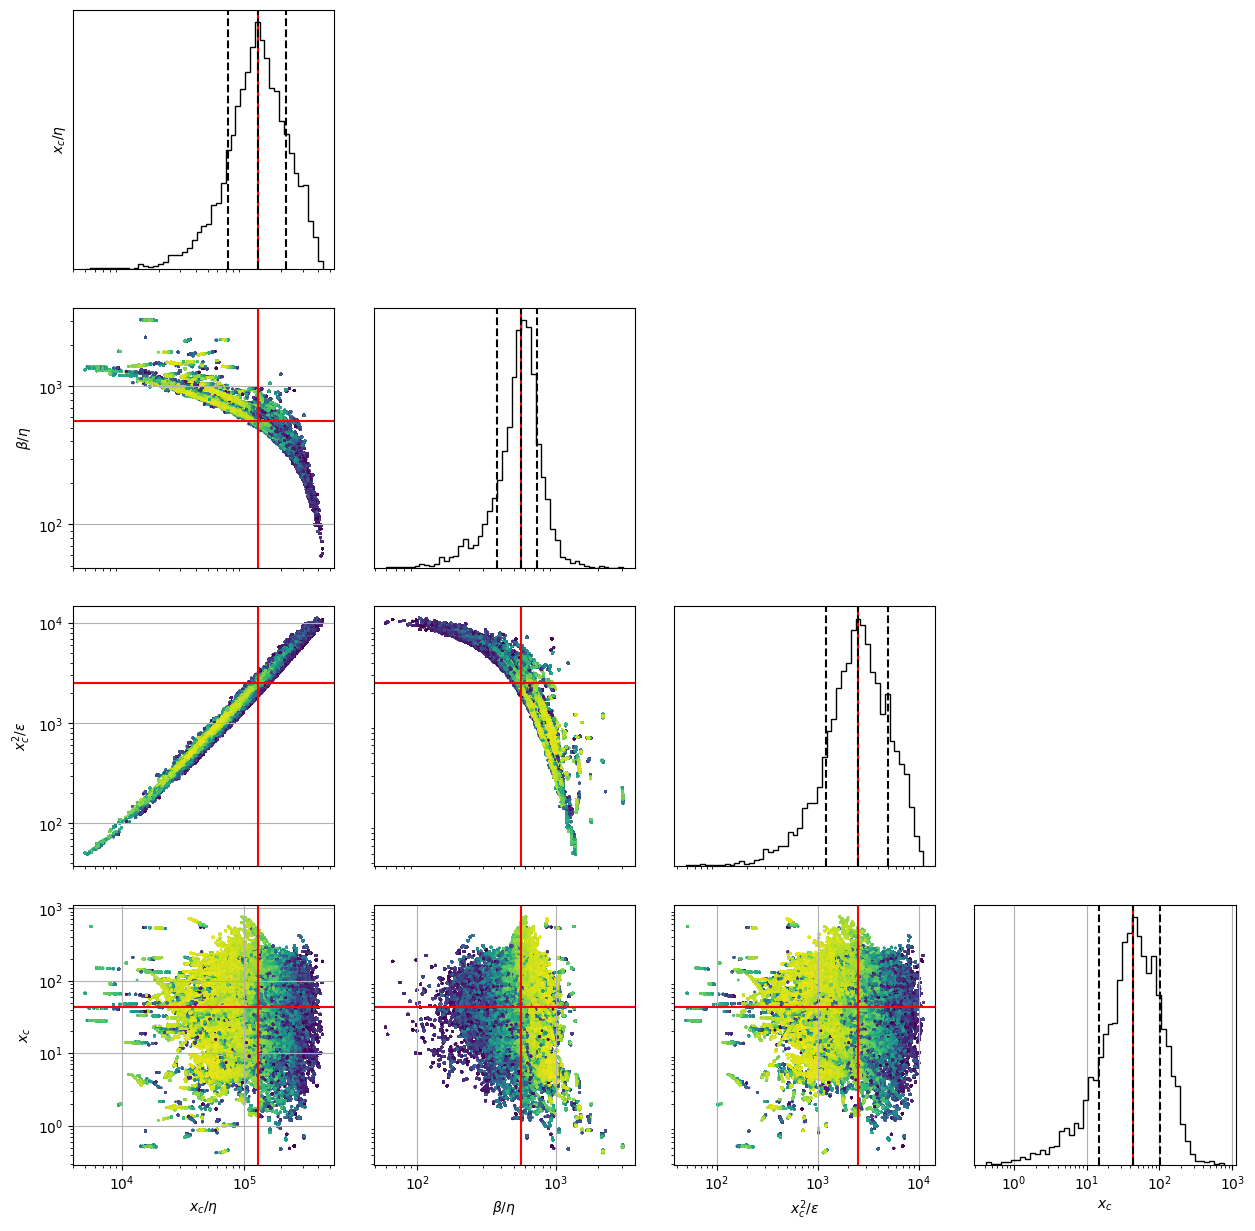

In [15]:
fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= medians_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"])

In [16]:

fact=1
import boltsman_stats as bs
dfb = bs.get_stats(samples, lnprobs,ds, file_path=temp_results_path,percent=False)

                               Eta  Beta  Epsilon     Xc  Beta/Eta  Beta*Xc/Eps  Fx=Beta^2/(Eta*Xc)  Dx=Beta*Eps/(Eta*Xc^2)  Xc^2/Eps  Beta*Kappa/Eps  Fk=Beta^2/(Eta*Kappa)  Dk=Beta*Eps/(Eta*Kappa^2)  s=(Xc^1.5*Eta^0.5)/Eps  Slope=Eta*Xc/Eps  Xc/Eps  Fk/Dk  Fk^2/Dk   t_eta  Median Lifetime
Best fit                   0.00130  1.11     5.73  62.01    824.86        11.97               14.72                    1.23    670.74           0.096                1825.12                   18916.97                    3.12            0.0150   10.82  0.096   176.09  215.03           882.00
Median                     0.00032  0.17     0.71  42.73    558.10        10.84                2.45                    0.22   2510.08           0.120                 186.45                    1459.46                    7.00            0.0200   60.99  0.120    26.80  357.69           882.00
Mean                       0.00061  0.43     5.65  58.50    566.55        10.46                5.89                    0.47   3

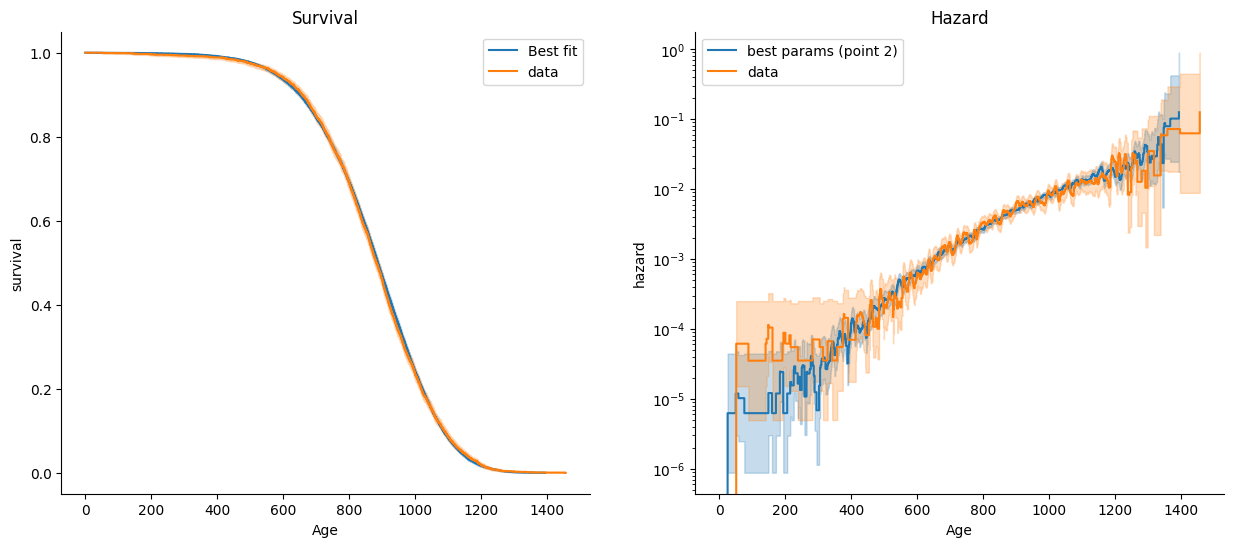

In [13]:
best_theta = sorted_samples[-1]
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

best_sim = srmc.getSr(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)
# median_sim = srmc.getSr(medians, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)
best_sim.bandwidth = 6
# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0], label='Best fit', title='Survival', xlabel='time [years]', ylabel='survival')
# median_sim.plotSurvival(ax=ax0, label='median params (point 1)', xlabel='time [years]')
ds.plotSurvival(ax=ax0, label='data')
ds.bandwidth = 6
# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params (point 2)')
# median_sim.plotHazard(ax=ax1, label='median params (point 1)')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

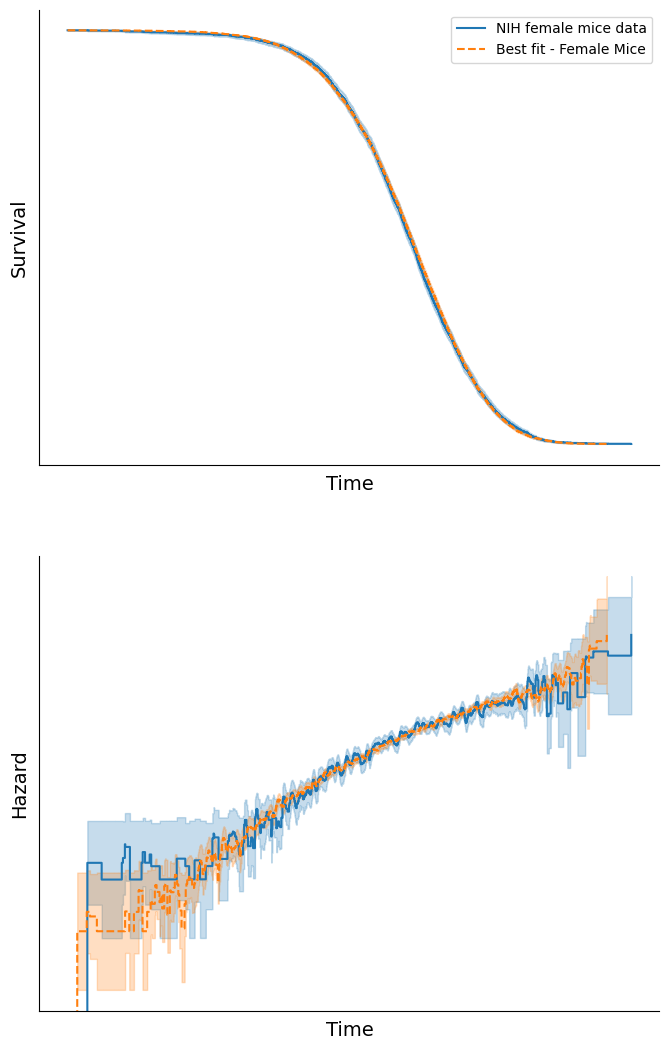

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(8, 13))
ds.plotSurvival(ax=axs[0], label='NIH female mice data')
ax0 = best_sim.plotSurvival(ax=axs[0], label='Best fit - Female Mice', title='Survival', xlabel='time [years]', ylabel='survival',ls='--')
ds.bandwidth = 6
ax0.set_ylabel('Survival', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title('')
#remove ticks and ticks label from all axis
ax0.tick_params(axis='both', which='both', length=0)
#remove legend from ax0

# Plot hazard on ax[1]
ds.plotHazard(ax=axs[1], label='NIH female mice data')
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time', ylabel='hazard', label='Best fit - Female Mice',ls='--')
ax1.set_ylabel('Hazard', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('')
#put legend on bottom right
ax0.legend(loc='upper right')
#remove ticks from all axis
ax1.tick_params(axis='both', which='both', length=0)
# median_sim.plotHazard(ax=ax1, label='median params (point 1)')
ax1.set_yscale('log')
#remove ticks labels
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xticklabels([])
ax1.get_legend().remove()


fig.savefig('plots/mice_F_best_fit.pdf',format='pdf')


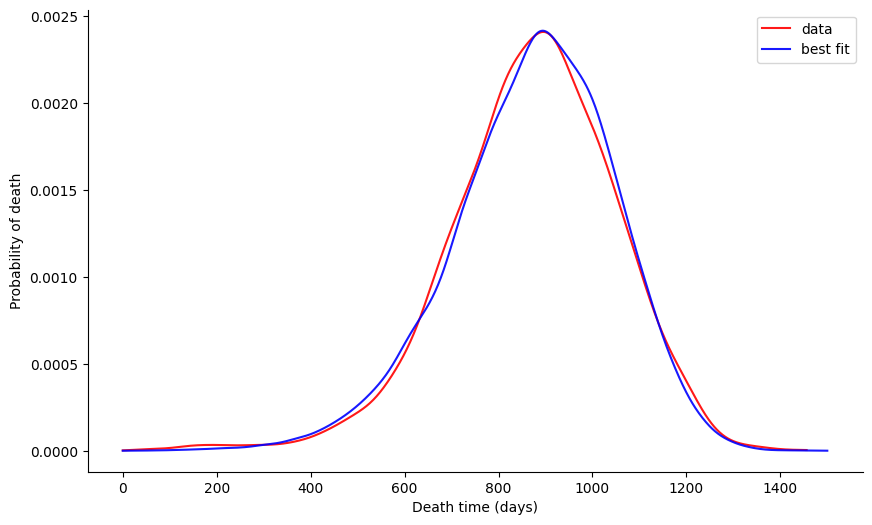

In [18]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))
ds.plotDeathTimesDistribution(ax=ax,use_kde=True, label='data', color='r',alpha=0.9)
best_sim.plotDeathTimesDistribution(ax=ax,use_kde=True, label='best fit', color='b',alpha=0.9)
ax.legend()


Averaging log-probabilities: 100%|██████████| 38630/38630 [00:00<00:00, 352295.45it/s]


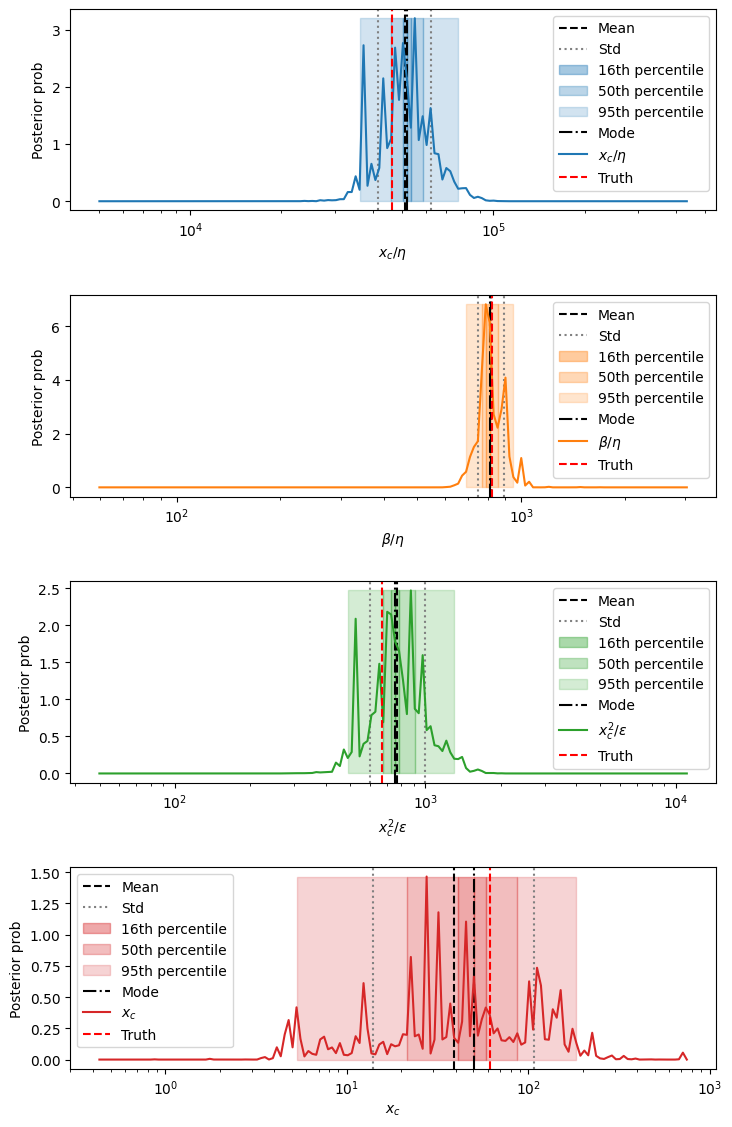

In [14]:
import samples_utils as su
post = su.Posterior(samples_trans, lnprobs, 150, log=True)
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log')

Creating corner plot: 100%|██████████| 4/4 [01:47<00:00, 26.87s/it]


array([[<Axes: xlabel='$x_c/\\eta$', ylabel='Posterior prob'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$\\beta/\\eta$'>,
        <Axes: xlabel='$\\beta/\\eta$', ylabel='Posterior prob'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: xlabel='$x_c^2/\\epsilon$', ylabel='Posterior prob'>,
        <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$x_c^2/\\epsilon$', ylabel='$x_c$'>,
        <Axes: xlabel='$x_c$', ylabel='Posterior prob'>]], dtype=object)

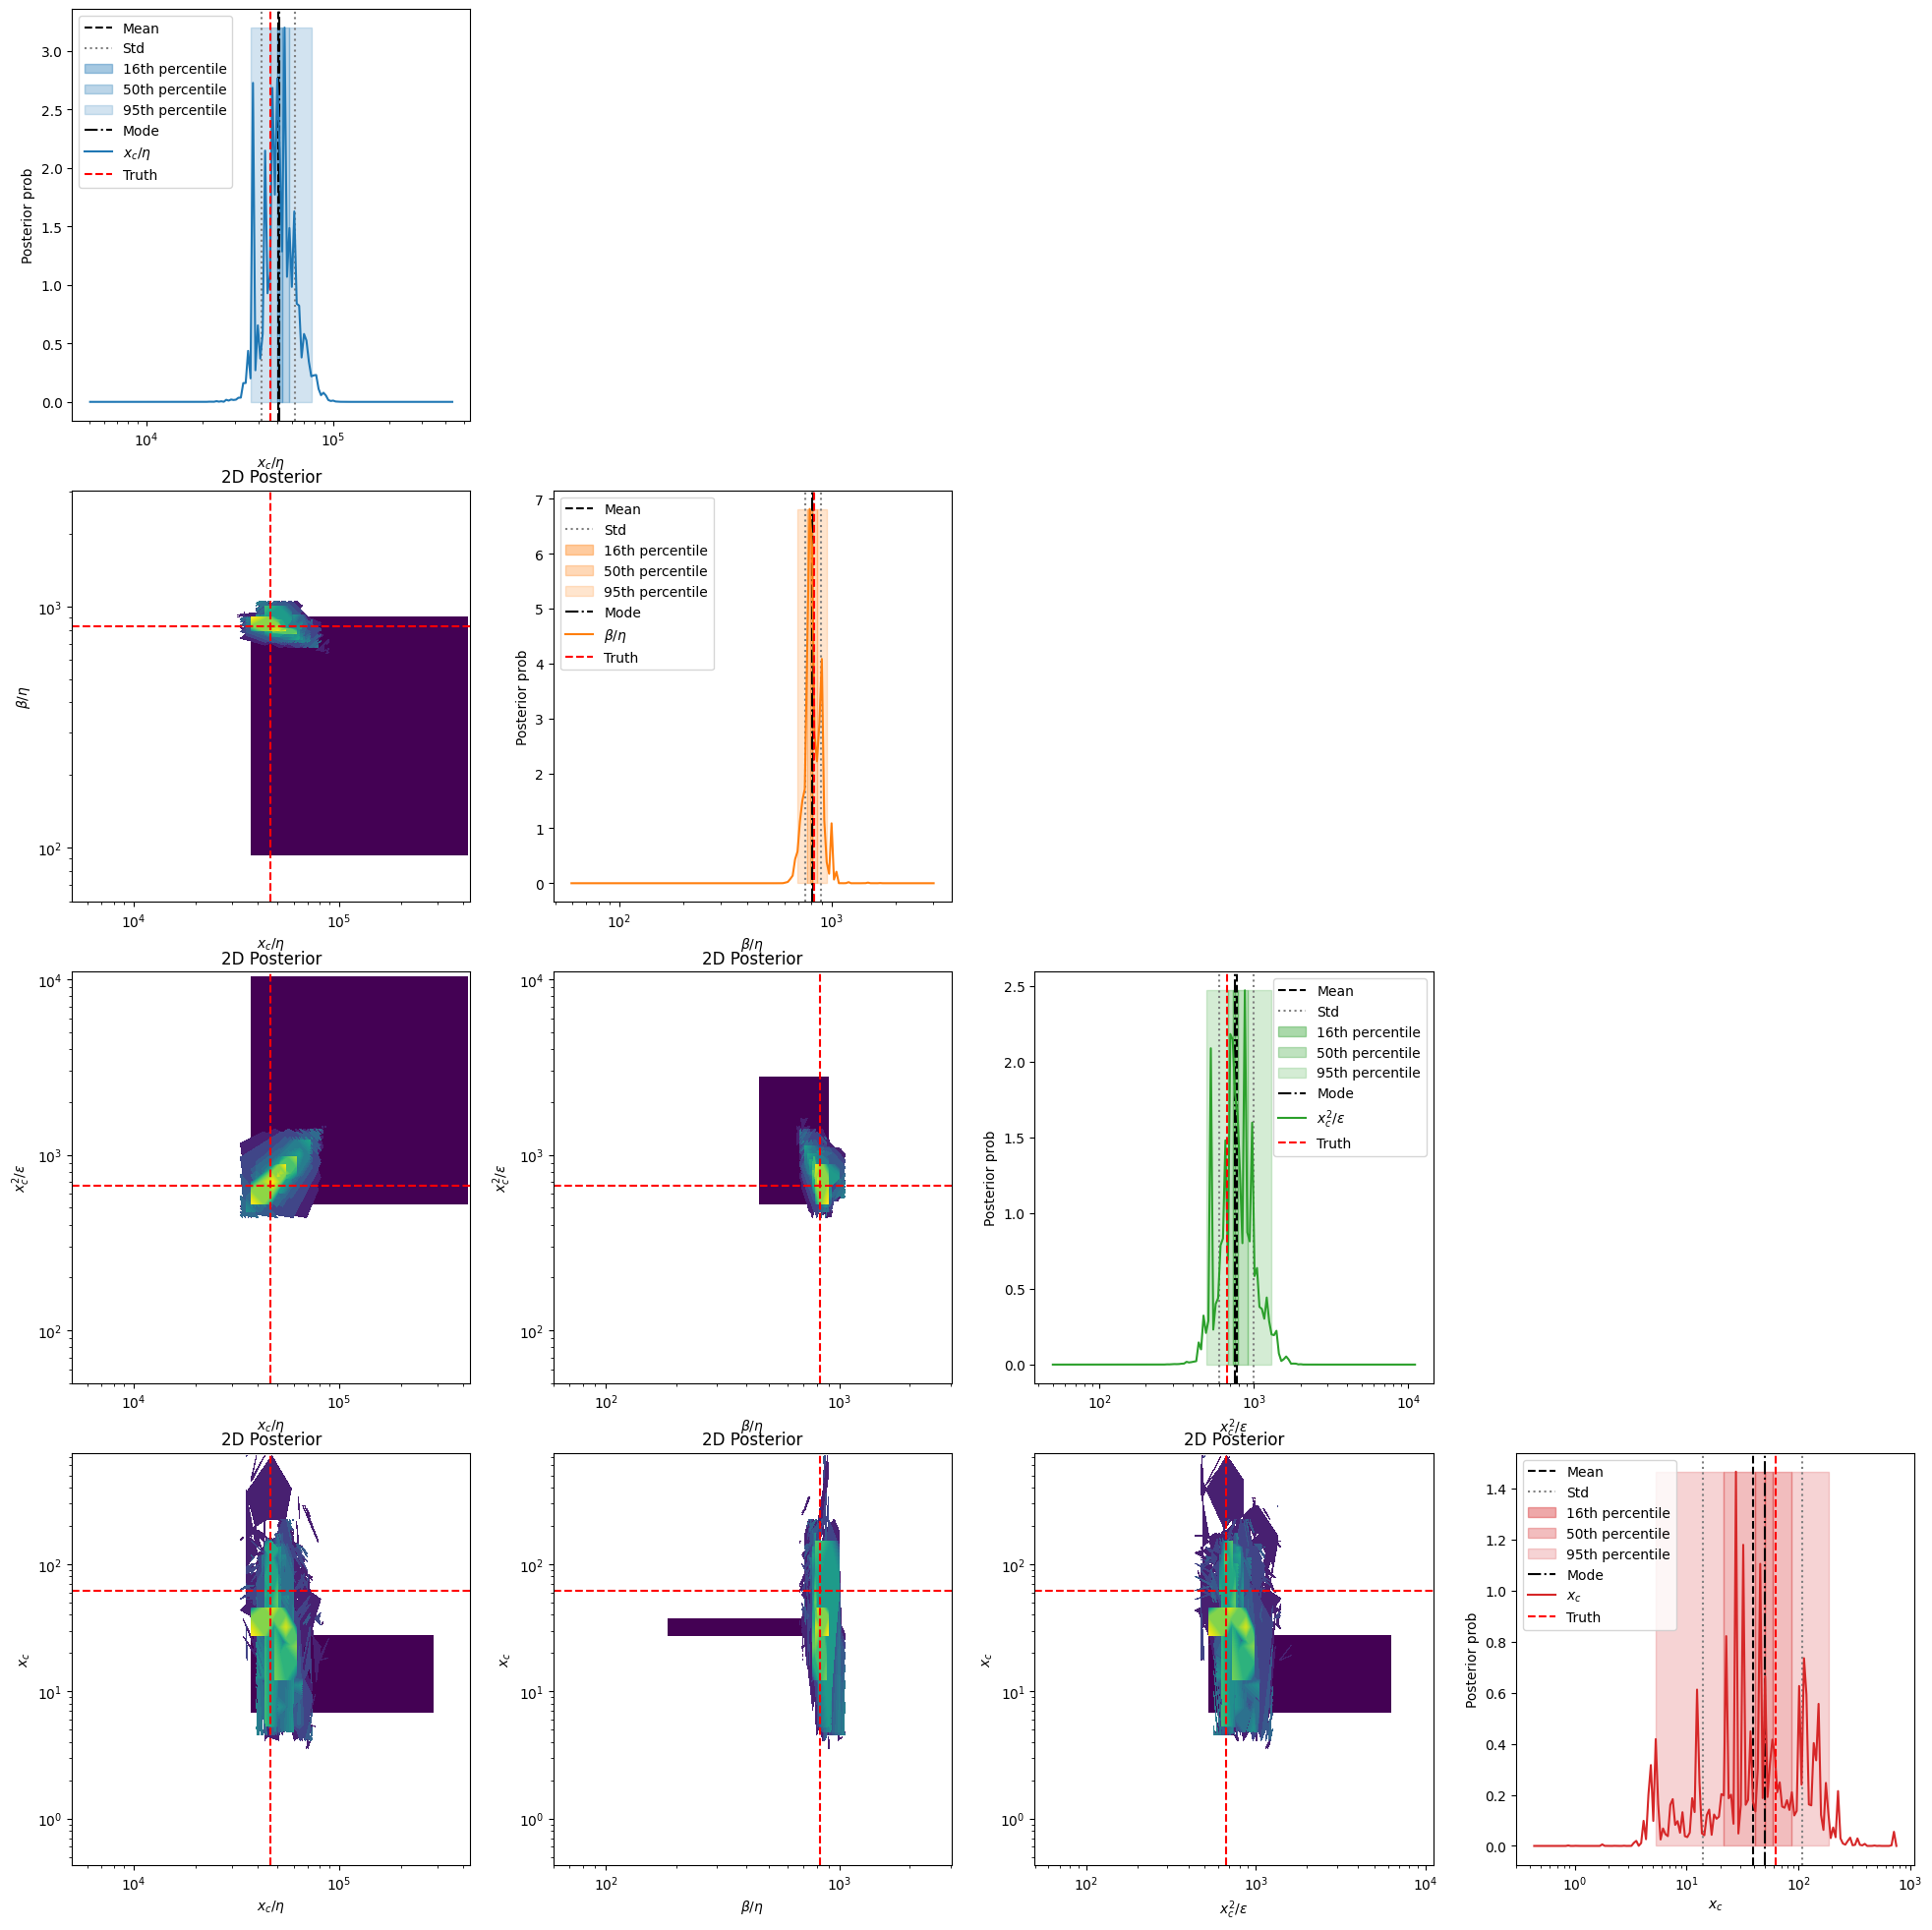

In [20]:
post.corner_plot(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log',show_ln_prob=False,norm='log')

In [15]:
df=post.create_posterior_df(filepath=results_path, ds = [best_sim,ds], ds_labels=['best fit','data'])

Averaging log-probabilities: 100%|██████████| 25403/25403 [00:00<00:00, 243274.50it/s]


In [16]:
#display the posterior df
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,50942.565,"[11336.891, 9273.207]",51832.668,"[50304.11, 53407.673]","[45983.624, 58425.702]","[36191.156, 76490.02]",46236.322
beta/eta,817.858,"[74.413, 68.207]",810.708,"[789.616, 810.708]","[769.074, 854.596]","[692.109, 949.629]",824.86
xc^2/epsilon,771.968,"[224.013, 173.629]",756.961,"[730.014, 784.903]","[678.964, 907.371]","[489.966, 1303.79]",670.741
xc,38.975,"[69.44, 24.964]",50.279,"[41.161, 58.421]","[21.48, 87.172]","[5.293, 184.617]",62.013
eta,0.0008,"[0.00155, 0.000528]",0.00264,"[0.00198, 0.00284]","[0.000775, 0.00305]","[9.58e-05, 0.00379]",0.00134
beta,0.667,"[1.213, 0.431]",0.71,"[0.609, 0.828]","[0.564, 1.927]","[0.0894, 2.828]",1.106
epsilon,2.072,"[15.599, 1.829]",20.192,"[15.696, 29.462]","[2.093, 33.416]","[0.0328, 48.758]",5.733
sqrt(xc/eta),227.789,"[24.004, 21.716]",227.668,"[224.286, 231.101]","[214.438, 241.714]","[190.24, 276.568]",215.026
s= eta^0.5*xc^1.5/epsilon,3.46,"[0.58, 0.497]",3.384,"[3.311, 3.459]","[3.102, 3.773]","[2.606, 4.691]",3.119
beta*xc/epsilon,12.262,"[0.778, 0.731]",12.234,"[12.234, 12.234]","[11.959, 12.803]","[11.69, 14.674]",11.966


In [18]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'
theta_mode =  df.loc[['eta','beta','epsilon','xc'],'mode'].values
print(f"theta_mode: {theta_mode}")
theta_mode_trans = df.loc[['xc/eta','beta/eta','xc^2/epsilon','xc'],'mode'].values
print(f"theta_mode_trans: {theta_mode_trans}")
sim_mode = srmc.getSr(theta_mode, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)
sim_mode_trans = srmc.getSr(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)


theta_mode: [0.000721 0.658 1.434 27.585]
theta_mode_trans: [55030.537 789.616 875.07 27.585]


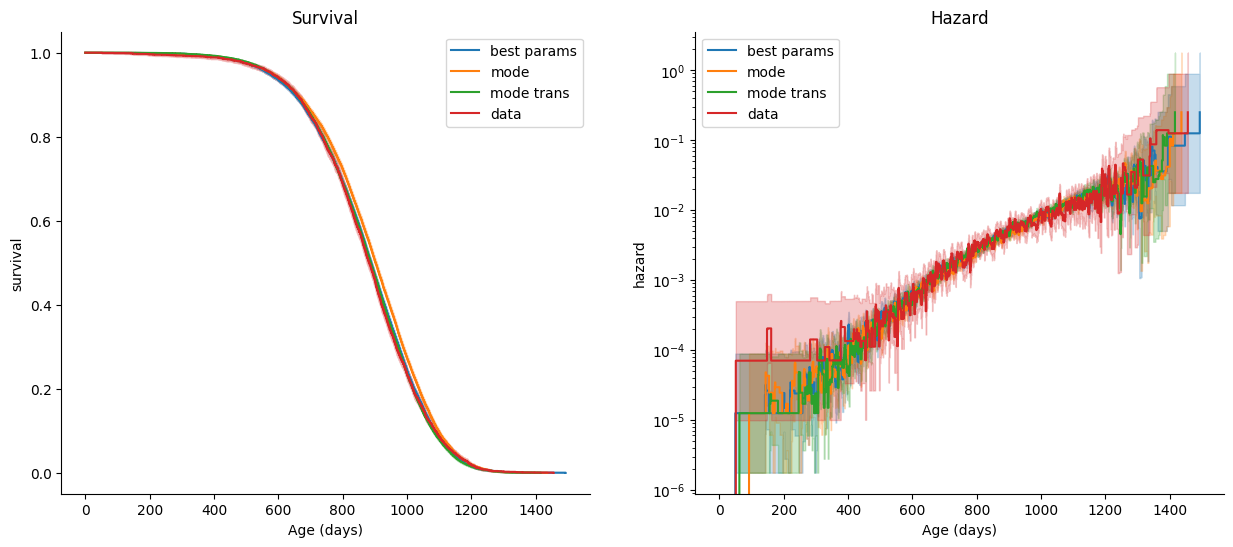

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0], label='best params', title='Survival', xlabel='time [years]', ylabel='survival')
sim_mode.plotSurvival(ax=ax0, label='mode')
sim_mode_trans.plotSurvival(ax=ax0, label='mode trans')
ds.plotSurvival(ax=ax0, label='data')

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params')
sim_mode.plotHazard(ax=ax1, label='mode')
sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

Averaging log-probabilities: 100%|██████████| 8241/8241 [00:00<00:00, 391350.60it/s]


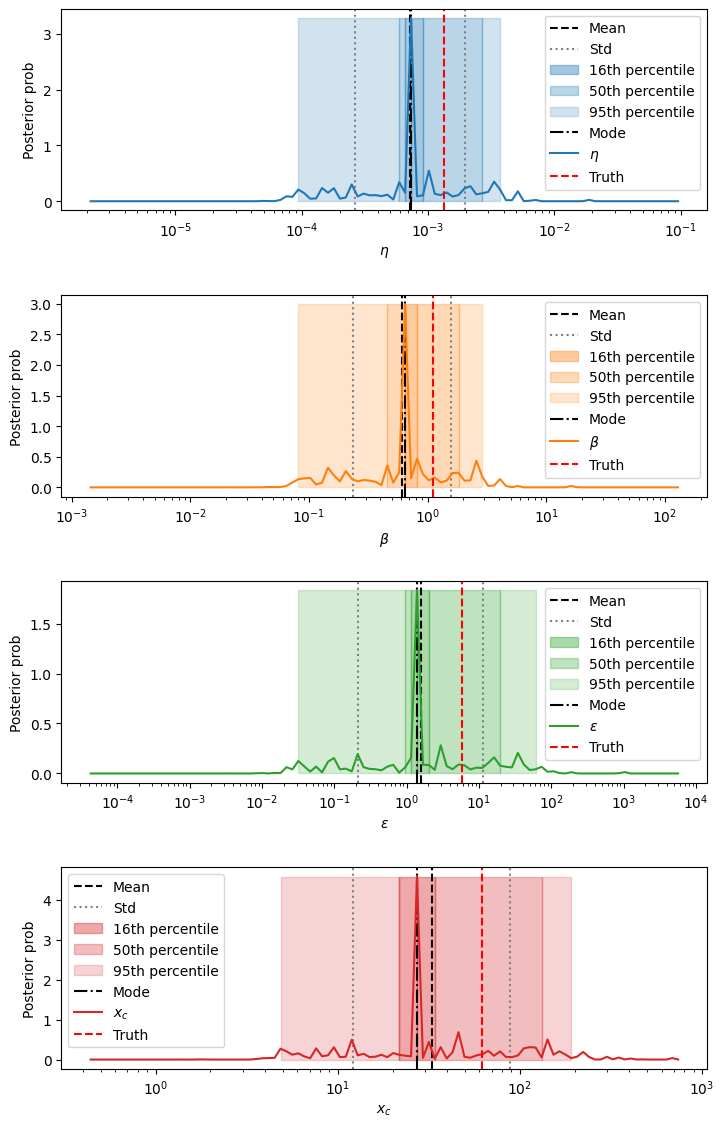

In [13]:
import samples_utils as su
post_regular_params = su.Posterior(samples, lnprobs, 100, log=True)
post_regular_params.plot_1d_posteriors(labels=["$\\eta$","$\\beta$","$\\epsilon$","$x_c$"], truths=sorted_samples[-1],scale='log')